# GroundingDINO Pipeline
This notebook extracts road sign of the 360 images with the help of the GroundingDINO model. The model is trained on the Open Images dataset and is able to detect objects in images based on a text prompt. The detected objects are then cropped and saved as individual images. The cropped images are then zipped and uploaded to a Google Cloud Storage bucket.

In [2]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
import numpy as np
from torchvision import transforms as T
from pytictoc import TicToc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import zipfile
import cv2
import os
import torch
from torchvision.ops import nms
import shutil
from google.cloud import storage
from PIL import Image
import tempfile
import gc


HOME = os.getcwd()
print(HOME)

/home/jupyter


## Images processing
360 images are stored in cloud bucket, sometimes the model crashes and we need to restart the process. To avoid processing the same image again, we need to list the images in the bucket and filter out the images that are already processed.

In [35]:
def list_images_in_bucket(bucket_name, prefix, project_id):
    """List all images in a specific bucket within a given prefix."""
    # Create a client using the given project ID
    storage_client = storage.Client(project=project_id)
    # Access the specified bucket
    bucket = storage_client.bucket(bucket_name)
    # Create an empty list to store the names of the images
    image_files = []

    # List all blobs in the specified bucket with the prefix 'raw/'
    blobs = bucket.list_blobs(prefix=prefix)
    for blob in blobs:
        if blob.name.lower().endswith(('.jpg')):
            image_files.append(blob.name)
            #print(blob.name)  # Print the file name

    return image_files

project_id = 'deep-learning-420208'
bucket_name = 'images-sign-recognition'
prefix = 'raw/'  # Adjust this as needed for your bucket's folder structure

image_list = list_images_in_bucket(bucket_name, prefix, project_id)
done = list_images_in_bucket(bucket_name, 'detected_objects/', project_id)
print(len(image_list))
print(len(done))

117
90


In [36]:
# Extract directory and file number from the 'done' filenames
done_keys = [d.split('/')[1].replace('.jpg', '').replace('_', '/') for d in done]

# Filter the to-do list to exclude images that are marked as 'done'
todo_list = [img for img in image_list if '/'.join(img.split('/')[1:3]).replace('.jpg', '') not in done_keys]

print(len(todo_list))

27


In [37]:
image_list = todo_list

In [15]:
def download_image_to_temp_file(bucket_name, blob_name, project_id):
    """Downloads an image to a temporary file and returns the file path."""
    client = storage.Client(project=project_id)
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    # Create a temporary file
    _, temp_local_filename = tempfile.mkstemp(suffix='.jpg')
    # Download the file from GCS
    blob.download_to_filename(temp_local_filename)
    return temp_local_filename

In [16]:
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    storage_client = storage.Client(project=project_id)
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    #print(f"File {source_file_name} uploaded to {destination_blob_name}.")

## Setup the GroundingDINO model
Use the custom kernel defined in the repo docker image, it has all the necessary packages installed. It has quite some

In [17]:
# PATH variiable setting for the custom kernel used in vertex AI workbench for the DINO model
original_path = os.environ.get('PATH', '')

# Define the path to the local bin directory
local_bin_path = '/home/jupyter/.local/bin'

# Check if the local bin path is already in PATH
if local_bin_path not in original_path:
    # Update the PATH environment variable
    os.environ['PATH'] = local_bin_path + ':' + original_path

print("Updated PATH:", os.environ['PATH'])


Updated PATH: /home/jupyter/.local/bin:/usr/local/cuda/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


In [4]:
# get repo
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

/home/jupyter
fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/home/jupyter/GroundingDINO


In [18]:
CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/home/jupyter/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [5]:
# get model
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/home/jupyter
mkdir: cannot create directory ‘/home/jupyter/weights’: File exists
/home/jupyter/weights


In [19]:
WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/home/jupyter/weights/groundingdino_swint_ogc.pth ; exist: True


In [20]:
%cd {HOME}/GroundingDINO

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/home/jupyter/GroundingDINO


final text_encoder_type: bert-base-uncased


## Image processing
The following code block processes the images in the bucket. It slides a window over the image and detects objects in the window. The detected objects are then cropped and saved as individual images. Overlapping bounding boxes are merged with Non-Maximum Suppression (NMS). The cropped images are then zipped and uploaded to a Google Cloud Storage bucket.

In [21]:
# Function to slide over the image and generate windows
def sliding_window(image, step_size, window_size):
    """ Slide a window across the image """
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

# Function to convert normalized coordinates to absolute coordinates
def convert_to_absolute(normalized_box, window_size):
    center_x, center_y, width, height = normalized_box
    abs_center_x = int(center_x * window_size[0])
    abs_center_y = int(center_y * window_size[1])
    abs_width = int(width * window_size[0])
    abs_height = int(height * window_size[1])
    # Convert from center to top-left corner
    top_left_x = abs_center_x - abs_width // 2
    top_left_y = abs_center_y - abs_height // 2
    return (top_left_x, top_left_y, abs_width, abs_height)

def convert_to_x1y1x2y2(boxes):
    """ Convert from [x, y, width, height] to [x1, y1, x2, y2] """
    converted_boxes = []
    for (x, y, w, h) in boxes:
        x2 = x + w
        y2 = y + h
        converted_boxes.append([x, y, x2, y2])
    return converted_boxes

def adjust_boxes(bounding_boxes, scores, offset_x, offset_y, window_size):
    adjusted_boxes = []
    adjusted_scores = []
    max_width_threshold = 0.95 * window_size[0]  # Filter out nearly full-width boxes
    max_height_threshold = 0.95 * window_size[1]  # Filter out nearly full-height boxes
    edge_margin = 10  # Margins in pixels from the edge of the window to consider a box touching it

    for box, score in zip(bounding_boxes, scores):
        top_left_x, top_left_y, width, height = convert_to_absolute(box, window_size)
        
        # Check if the box is touching the edge of the window
        if (top_left_x <= edge_margin or top_left_y <= edge_margin or
            top_left_x + width >= window_size[0] - edge_margin or
            top_left_y + height >= window_size[1] - edge_margin):
            continue  # Skip boxes touching the edge, as they are likely to be incomplete and will be processed in the next window
        
        # Filter out large boxes that cover almost the entire window
        if width > max_width_threshold or height > max_height_threshold:
            continue  # Skip this box
            
        if width < 25 or height < 25:
            continue

        adjusted_boxes.append((top_left_x + offset_x, top_left_y + offset_y, width, height))
        adjusted_scores.append(score)  # Keep the score for the boxes that were not filtered out

    return adjusted_boxes, adjusted_scores

In [22]:
# setup for DINO, tried different values for the threshold and the prompt text. The values below are the most useful.
TEXT_PROMPT = "road signs"
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25

In [ ]:
t = TicToc()  # Create instance of class

t.tic()
done = 0

# Function to slide over the image and generate windows
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

for image in image_list:
    # Load the large image
    IMAGE_NAME = "22.jpg"
    IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)
    # Use your bucket name and the path to your file within the bucket
    temp_image_path = download_image_to_temp_file('images-sign-recognition', image, project_id)
    large_image = cv2.imread(temp_image_path)
    large_image = cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    # Define window size and overlap
    window_size = (1024, 1024)  # Window size (width, height)
    step_size = int(window_size[0] * 0.5)  # 50% overlap
    
    # Define a temporary directory for image files
    temp_dir = "temp_images"
    os.makedirs(temp_dir, exist_ok=True)
    
    all_boxes = []  # List to store all bounding boxes
    all_scores = []  # List to store corresponding scores, if your model provides them
    
    # Process each window
    for i, (x, y, window) in enumerate(sliding_window(large_image, step_size, window_size)):
        if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
            continue  # Skip incomplete windows
    
        # Save the window to a temporary file
        temp_path = os.path.join(temp_dir, f"temp_{i}.jpg")
        Image.fromarray(window).save(temp_path)
    
        # Load the image using the provided load_image function
        image_source, image_transformed = load_image(temp_path)
    
        # Replace this with your actual model's prediction method
        boxes, logits, phrases = predict(
            model=model,
            image=image_transformed,
            caption=TEXT_PROMPT,
            box_threshold=BOX_THRESHOLD,
            text_threshold=TEXT_THRESHOLD
        )
    
        normalized_boxes = boxes
        absolute_boxes, absolute_scores = adjust_boxes(normalized_boxes, logits, x, y, window_size)
    
        all_boxes.extend(absolute_boxes)
        all_scores.extend(absolute_scores)
    
        # Clean up the temporary file
        os.remove(temp_path)
    
    # Apply Non-Maximum Suppression (NMS)
    all_boxes_converted = convert_to_x1y1x2y2(all_boxes)
    boxes_tensor = torch.tensor(all_boxes_converted, dtype=torch.float32)  # [N, 4]
    scores_tensor = torch.tensor(all_scores, dtype=torch.float32)  # [N]
    keep_indices = nms(boxes_tensor, scores_tensor, iou_threshold=0.7)  # Adjust IOU threshold as needed
    final_boxes = [all_boxes[i] for i in keep_indices]
    
    # Draw remaining boxes
    for box in final_boxes:
        top_left_x, top_left_y, width, height = box
        cv2.rectangle(large_image, (top_left_x, top_left_y), (top_left_x + width, top_left_y + height), (0, 255, 0), 2)
    
    # Save or show the result
    # image name is in the form of 'raw/N632/38.jpg' raw - road - number
    _, road, number = image.split('/')
    number = number.split('.')[0]
    cv2.imwrite(f'../data/detected_objects/{road}_{number}.jpg', cv2.cvtColor(large_image, cv2.COLOR_RGB2BGR))  # Convert RGB back to BGR for saving
    detected_objects_path = os.path.join(HOME, "data", "detected_objects", f"{road}_{number}.jpg")
    upload_blob(bucket_name, detected_objects_path, f'detected_objects/{road}_{number}.jpg')
    # cv2.imshow('Detected Objects', large_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    large_image = cv2.imread(temp_image_path)
    large_image = cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    # Directory where cropped images will be saved
    crop_dir = "cropped_images"
    IMAGE_PATH = os.path.join(HOME, "data", crop_dir)
    #shutil.rmtree(IMAGE_PATH)
    os.makedirs(IMAGE_PATH, exist_ok=True)
    
    # Save each cropped image
    for i, (top_left_x, top_left_y, width, height) in enumerate(final_boxes):
        # Crop the image using numpy slicing
        cropped_image = large_image[top_left_y:top_left_y+height, top_left_x:top_left_x+width]
    
        # Convert numpy array to PIL Image for saving
        cropped_image_pil = Image.fromarray(cropped_image)
    
        # Save the cropped image
        cropped_image_path = os.path.join(IMAGE_PATH, f"{road}_{number}_{top_left_x}_{top_left_y}_{width}_{height}.jpg")
        #print(cropped_image_path.split("/")[-1])
        cropped_image_pil.save(cropped_image_path)
        blob_path = f'crops/{cropped_image_path.split("/")[-1]}'
        upload_blob(bucket_name, cropped_image_path, blob_path)
    
        #print(f"Cropped image saved to {cropped_image_path}")
    
    #print("All cropped images are saved in:", crop_dir)
    
    # Optionally, remove the temp directory if empty
    os.rmdir(temp_dir)
    os.remove(temp_image_path)
    shutil.rmtree(IMAGE_PATH)
    done = done + 1
    print(f'Image {image} Done.   ---   [{done}/{len(image_list)}: {done/len(image_list)}%]')
    gc.collect()
t.toc()


Image raw/N65/19.jpg Done.   ---   [1/27: 0.037037037037037035%]


Image raw/N65/2.jpg Done.   ---   [2/27: 0.07407407407407407%]


Image raw/N65/20.jpg Done.   ---   [3/27: 0.1111111111111111%]


Image raw/N65/21.jpg Done.   ---   [4/27: 0.14814814814814814%]


Image raw/N65/22.jpg Done.   ---   [5/27: 0.18518518518518517%]


Image raw/N65/23.jpg Done.   ---   [6/27: 0.2222222222222222%]


Image raw/N65/24.jpg Done.   ---   [7/27: 0.25925925925925924%]


Image raw/N65/25.jpg Done.   ---   [8/27: 0.2962962962962963%]


Image raw/N65/26.jpg Done.   ---   [9/27: 0.3333333333333333%]


Image raw/N65/27.jpg Done.   ---   [10/27: 0.37037037037037035%]


Image raw/N65/28.jpg Done.   ---   [11/27: 0.4074074074074074%]


Image raw/N65/29.jpg Done.   ---   [12/27: 0.4444444444444444%]


Image raw/N65/3.jpg Done.   ---   [13/27: 0.48148148148148145%]


Image raw/N65/30.jpg Done.   ---   [14/27: 0.5185185185185185%]


Image raw/N65/31.jpg Done.   ---   [15/27: 0.5555555555555556%]


Image raw/N65/32.jpg Done.   ---   [16/27: 0.5925925925925926%]


Image raw/N65/33.jpg Done.   ---   [17/27: 0.6296296296296297%]


Image raw/N65/34.jpg Done.   ---   [18/27: 0.6666666666666666%]


Image raw/N65/35.jpg Done.   ---   [19/27: 0.7037037037037037%]


Image raw/N65/36.jpg Done.   ---   [20/27: 0.7407407407407407%]


Image raw/N65/37.jpg Done.   ---   [21/27: 0.7777777777777778%]


## Below code is for testing and saving intermediate results

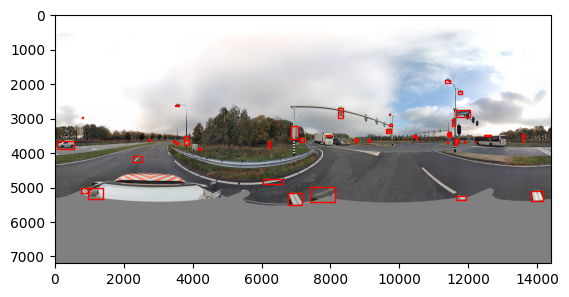

In [114]:
def plot_image_with_boxes(image, boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box in boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

plot_image_with_boxes(large_image, final_boxes)


In [115]:
# Load the large image
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)
large_image = cv2.imread(IMAGE_PATH)
large_image = cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Directory where cropped images will be saved
crop_dir = "cropped_images"
IMAGE_PATH = os.path.join(HOME, "data", crop_dir)
shutil.rmtree(IMAGE_PATH)
os.makedirs(IMAGE_PATH, exist_ok=True)

# Save each cropped image
for i, (top_left_x, top_left_y, width, height) in enumerate(final_boxes):
    # Crop the image using numpy slicing
    cropped_image = large_image[top_left_y:top_left_y+height, top_left_x:top_left_x+width]

    # Convert numpy array to PIL Image for saving
    cropped_image_pil = Image.fromarray(cropped_image)

    # Save the cropped image
    cropped_image_path = os.path.join(IMAGE_PATH, f"crop_{i}.jpg")
    cropped_image_pil.save(cropped_image_path)

    print(f"Cropped image saved to {cropped_image_path}")

print("All cropped images are saved in:", crop_dir)


Cropped image saved to /home/jupyter/data/cropped_images/crop_0.jpg
Cropped image saved to /home/jupyter/data/cropped_images/crop_1.jpg
Cropped image saved to /home/jupyter/data/cropped_images/crop_2.jpg
Cropped image saved to /home/jupyter/data/cropped_images/crop_3.jpg
Cropped image saved to /home/jupyter/data/cropped_images/crop_4.jpg
Cropped image saved to /home/jupyter/data/cropped_images/crop_5.jpg
Cropped image saved to /home/jupyter/data/cropped_images/crop_6.jpg
Cropped image saved to /home/jupyter/data/cropped_images/crop_7.jpg
Cropped image saved to /home/jupyter/data/cropped_images/crop_8.jpg
Cropped image saved to /home/jupyter/data/cropped_images/crop_9.jpg
Cropped image saved to /home/jupyter/data/cropped_images/crop_10.jpg
Cropped image saved to /home/jupyter/data/cropped_images/crop_11.jpg
Cropped image saved to /home/jupyter/data/cropped_images/crop_12.jpg
Cropped image saved to /home/jupyter/data/cropped_images/crop_13.jpg
Cropped image saved to /home/jupyter/data/cr

In [116]:
# Zip the cropped images
crop_dir = IMAGE_PATH

zip_path = os.path.join(crop_dir, "cropped_images.zip")

# Create a Zip
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for root, dirs, files in os.walk(crop_dir):
        for file in files:
            if file.endswith('.jpg'):
                filepath = os.path.join(root, file)
                zipf.write(filepath, os.path.relpath(filepath, crop_dir))

print(f"All cropped images have been zipped in: {zip_path}")


All cropped images have been zipped in: /home/jupyter/data/cropped_images/cropped_images.zip
